In [1]:
# Importing necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define paths for images and labels
train_image_dir = "BoneFractureYolo8/train/images"  # Replace with the actual path to the train image folder
train_label_dir = "BoneFractureYolo8/train/labels"  # Replace with the actual path to the train label folder

# Check the number of images and labels
image_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.jpg') or f.endswith('.png')])
label_files = sorted([f for f in os.listdir(train_label_dir) if f.endswith('.txt')])

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

# Ensure that each image has a corresponding label file
assert len(image_files) == len(label_files), "Mismatch between number of images and labels!"
for img, lbl in zip(image_files, label_files):
    assert os.path.splitext(img)[0] == os.path.splitext(lbl)[0], f"Image {img} does not match label {lbl}!"

# Function to parse a single label file
def parse_label_file(label_path):
    """
    Parse a YOLO-style label file.
    Returns a list of dictionaries containing class and bounding box information.
    """
    with open(label_path, 'r') as file:
        lines = file.readlines()
        labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels.append({'class': class_id, 'bbox': bbox})
        return labels




Number of images: 3631
Number of labels: 3631


C:\Users\anish\AppData\Local\Temp\ipykernel_26876\20140177.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


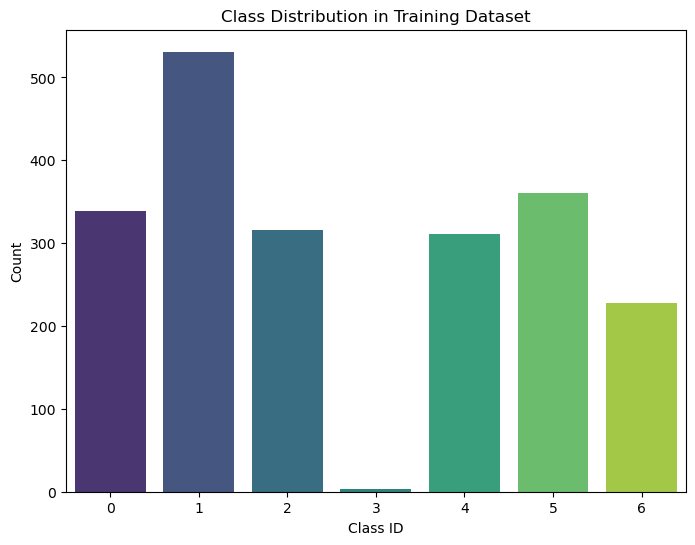

In [3]:
# Analyze class distribution in the training dataset
class_counts = {}
for label_file in label_files:
    label_path = os.path.join(train_label_dir, label_file)
    labels = parse_label_file(label_path)
    for label in labels:
        class_id = label['class']
        class_counts[class_id] = class_counts.get(class_id, 0) + 1

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

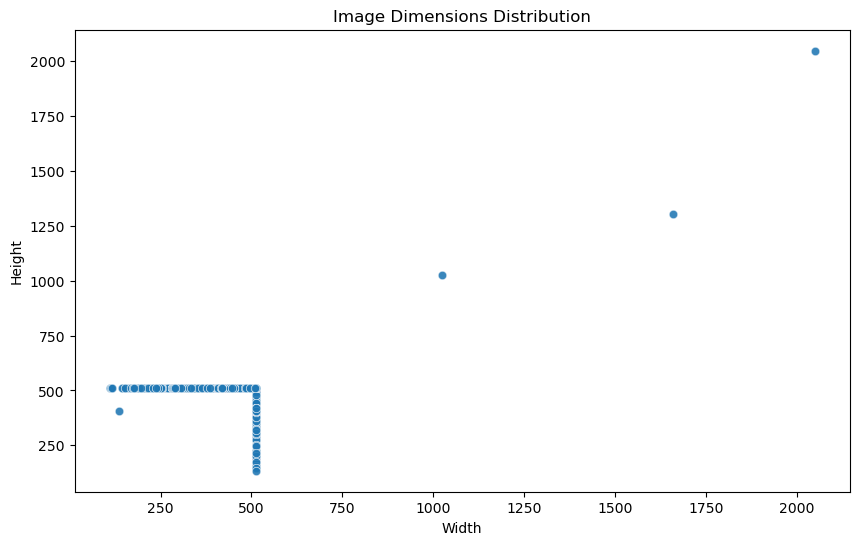

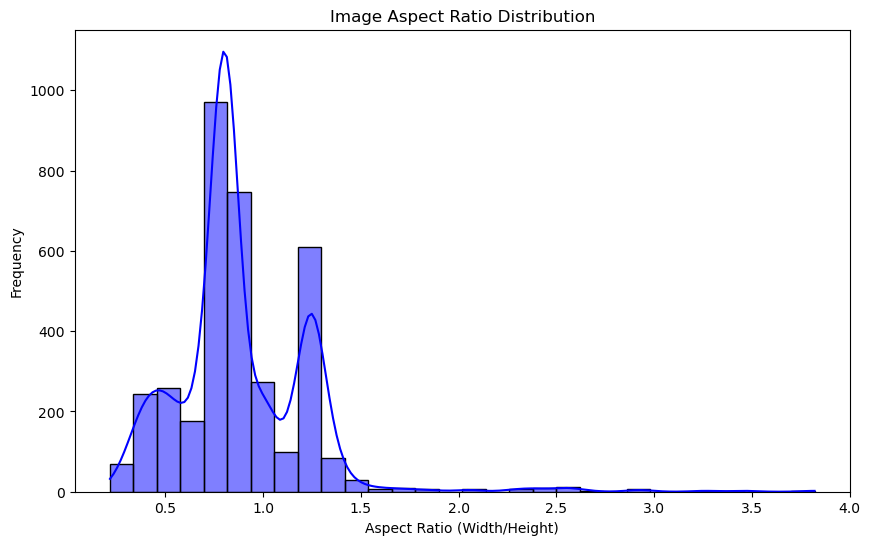

In [ ]:

# Analyze image dimensions and aspect ratios
image_shapes = []
for img_file in image_files:
    img_path = os.path.join(train_image_dir, img_file)
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

# Convert image dimensions to DataFrame for analysis
image_data = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
image_data['AspectRatio'] = image_data['Width'] / image_data['Height']

# Plot distribution of image dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=image_data, x='Width', y='Height', alpha=0.5)
plt.title("Image Dimensions Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

# Plot aspect ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(image_data['AspectRatio'], bins=30, kde=True, color='blue')
plt.title("Image Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.show()


In [10]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/images/*.jpg'))
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return item
    
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [float(value) for value in line.split()]
                label = int(values[0])
                coords = values[1:]
                coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                min_coords = torch.min(coords, dim=0).values * size
                max_coords = torch.max(coords, dim=0).values * size
                box = torch.cat((min_coords, max_coords), dim=0).tolist()
                labels.append(label)
                boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.ByteTensor(boxes)
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

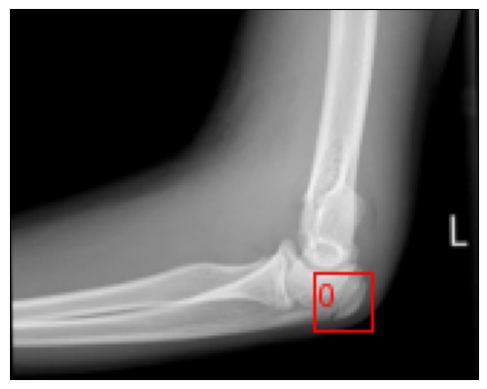

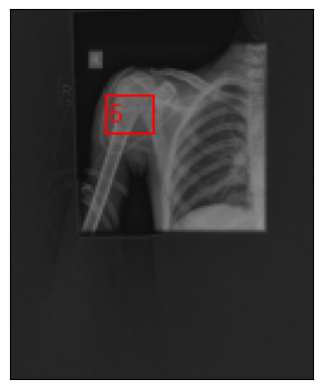

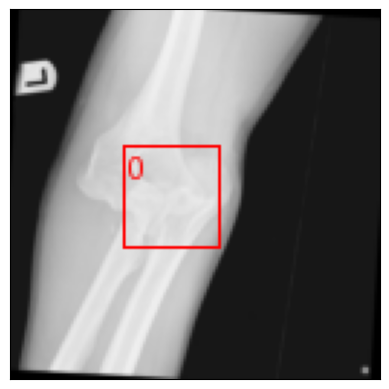

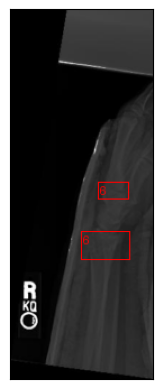

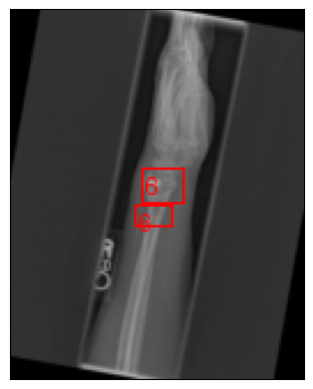

In [12]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

def show(imgs):
    """
    Display one or more images using Matplotlib.
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

load_shape = 128

transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
])

dataset = ImageDataset("BoneFractureYolo8", transform=transform)

# Visualize bounding boxes for specific indices in the dataset
for index in [8, 1264, 5, 876, 15]:
    # Get image and convert to uint8 format
    img = F.convert_image_dtype(dataset.get_image(index), dtype=torch.uint8)
    
    # Draw bounding boxes on the image
    drawn_boxes = draw_bounding_boxes(
        img,
        boxes=dataset.get_boxes(index),  # Bounding box coordinates
        colors="red",                   # Box color
        labels=[str(x) for x in dataset.get_labels(index)]  # Class labels
    )
    
    # Display the image with bounding boxes
    show(drawn_boxes)
